# Contextual Bandits with Amazon SageMaker RL

We demonstrate how you can manage your own contextual multi-armed bandit workflow on SageMaker using the built-in [Vowpal Wabbit (VW)](https://github.com/VowpalWabbit/vowpal_wabbit) container to train and deploy contextual bandit models. We show how to train these models that interact with a live environment (using a simulated client application) and continuously update the model with efficient exploration.

### Why Contextual Bandits?

Wherever we look to personalize content for a user (content layout, ads, search, product recommendations, etc.), contextual bandits come in handy. Traditional personalization methods collect a training dataset, build a model and deploy it for generating recommendations. However, the training algorithm does not inform us on how to collect this dataset, especially in a production system where generating poor recommendations lead to loss of revenue. Contextual bandit algorithms help us collect this data in a strategic manner by trading off between exploiting known information and exploring recommendations which may yield higher benefits. The collected data is used to update the personalization model in an online manner. Therefore, contextual bandits help us train a personalization model while minimizing the impact of poor recommendations.

### What does this notebook contain?

To implement the exploration-exploitation strategy, we need an iterative training and deployment system that: (1) recommends an action using the contextual bandit model based on user context, (2) captures the implicit feedback over time and (3) continuously trains the model with incremental interaction data. In this notebook, we show how to setup the infrastructure needed for such an iterative learning system. While the example demonstrates a bandits application, these continual learning systems are useful more generally in dynamic scenarios where models need to be continually updated to capture the recent trends in the data (e.g. tracking fraud behaviors based on detection mechanisms or tracking user interests over time). 

In a typical supervised learning setup, the model is trained with a SageMaker training job and it is hosted behind a SageMaker hosting endpoint. The client application calls the endpoint for inference and receives a response. In bandits, the client application also sends the reward (a score assigned to each recommendation generated by the model) back for subsequent model training. These rewards will be part of the dataset for the subsequent model training. 

<p align="center">
  <img src="workflow.png">
</p>

The contextual bandit training workflow is controlled by an experiment manager provided with this example. The client application (say a recommender system application) pings the SageMaker hosting endpoint that is serving the bandits model. The application sends the state (user features) as input and receives an action (recommendation) as a response. The client application sends the recommended action to the user and stores the received reward in S3. The SageMaker hosted endpoint also stores inference data (state and action) in S3. The experiment manager joins the inference data with rewards as they become available. The joined data is used to update the model with a SageMaker training job. The updated model is evaluated offline and deployed to SageMaker hosting endpoint if the model evaluation score improves upon prior models. 

Below is an overview of the subsequent cells in the notebook: 
* Configuration: this includes details related to SageMaker and other AWS resources needed for the bandits application. 
* IAM role setup: this creates appropriate execution role and shows how to add more permissions to the role, needed for specific AWS resources.
* Client application (Environment): this shows the simulated client application.
* Step-by-step bandits model development: 
 1. Model Initialization (random or warm-start) 
 2. Deploy the First Model 
 3. Initialize the Client Application 
 4. Reward Ingestion 
 5. Model Re-training and Re-deployment 
* Bandits model deployment with the end-to-end loop. 
* Visualization 
* Cleanup 

#### Local Mode

To facilitate experimentation, we provide a `local_mode` that runs the contextual bandit example using the SageMaker Notebook instance itself instead of SageMaker training and hosting instances. The workflow remains the same in `local_mode`, but runs much faster for small datasets. Hence, it is a useful tool for experimentation and debugging. However, it will not scale to production use cases with high throughput and large datasets. 

In `local_mode`, the training, evaluation and hosting is done with the SageMaker VW docker container. The join is not handled by SageMaker, and is done inside the client application. The rest of the textual explanation assumes that the notebook is run in SageMaker mode.

In [1]:
import yaml
import sys
import numpy as np
import time
import sagemaker
sys.path.append('common')
sys.path.append('common/sagemaker_rl')
from misc import get_execution_role
from markdown_helper import *
from IPython.display import Markdown

### Configuration

The configuration for the bandits application can be specified in a `config.yaml` file as can be seen below. It configures the AWS resources needed. The DynamoDB tables are used to store metadata related to experiments, models and data joins. The `private_resource` specifices the SageMaker instance types and counts used for training, evaluation and hosting. The SageMaker container image is used for the bandits application. This config file also contains algorithm and SageMaker-specific setups.  Note that all the data generated and used for the bandits application will be stored in `S3://SageMaker-{REGION}-{AWS_ACCOUNT_ID}/{experiment_id}/`.

In [2]:
!pygmentize 'config.yaml'
config_file = 'config.yaml'
with open(config_file, 'r') as yaml_file:
    config = yaml.load(yaml_file)

resource:
  shared_resource:
    # cloud formation stack
    resources_cf_stack_name: "BanditsSharedResourceStack"
    # Dynamo table for status of an experiment
    experiment_db:
      table_name: "BanditsExperimentTable"
    # Dynamo table for status of all models trained
    model_db:
      table_name: "BanditsModelTable"
    # Dynamo table for status of all joining job for reward ingestion
    join_db:
      table_name: "BanditsJoinTable"
    iam_role:
      role_name: "BanditsIAMRole"
  private_resource:
    hosting_fleet:
      instance_type: "ml.t2.medium"
      instance_count: 1
    training_fleet:
      instance_type: "ml.c5.4xlarge"
    evaluation_fleet:
      instance_type: "ml.c5.4xlarge"
# Vowpal Wabbit container
image: "462105765813.dkr.ecr.{AWS_REGION}.amazonaws.com/sagemaker-rl-vw-container:vw-8.7.0-cpu"
# Vowpal Wabbit algorithm parameters
algor:
  algorithms_parameters:
    exploration_policy: "egreedy" # supports "egreedy", "bag", "cover"
    epsilon: 0.001 # used i

> Please make sure that the `num_arms` parameter in the config is equal to the number of actions in the client application (which is defined in the cell below).

### IAM role setup
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use `utils` method `role = get_execution_role('role_name')` to create an execution role.

In [3]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::815068530276:role/service-role/AmazonSageMaker-ExecutionRole-20191027T013543


#### Additional permissions for the IAM role
IAM role requires additional permissions for [AWS CloudFormation](https://aws.amazon.com/cloudformation/), [Amazon DynamoDB](https://aws.amazon.com/dynamodb/), [Amazon Kinesis Data Firehose](https://aws.amazon.com/kinesis/data-firehose/) and [Amazon Athena](https://aws.amazon.com/athena/). Make sure the SageMaker role you are using has the permissions.

In [4]:
display(Markdown(generate_help_for_experiment_manager_permissions(sagemaker_role)))

>It looks like your SageMaker role has insufficient premissions. Please do the following:
1. Go to IAM console to edit current SageMaker role: [AmazonSageMaker-ExecutionRole-20191027T013543](https://console.aws.amazon.com/iam/home#/roles/AmazonSageMaker-ExecutionRole-20191027T013543).
2. Click on policy starting with `AmazonSageMaker-ExecutionPolicy` and then edit policy.
3. Go to JSON tab, add the following JSON blob to the `Statement` list and save policy:
```json
        {
            "Effect": "Allow",
            "Action": [
                "firehose:*",
                "cloudformation:*",
                "dynamodb:*",
                "iam:*",
                "cloudwatch:*",
                "glue:*",
                "athena:*"
            ],
            "Resource": [
                "*"
            ]
        },```
4. Now wait for a few minutes before executing this cell again!

### Client application (Environment)
The client application simulates a live environment that uses the SageMaker bandits model to serve recommendations to users. The logic of reward generation resides in the client application. We simulate the online learning loop with feedback using the [Statlog (Shuttle) Data Set](https://archive.ics.uci.edu/ml/datasets/Statlog+(Shuttle)). The data consists of 7 classes, and if the agent selects the right class, then reward is 1. Otherwise, the agent obtains a reward 0.

The workflow of the client application is as follows:
- The client application picks a context at random, which is sent to the SageMaker endpoint for retrieving an action.
- SageMaker endpoint returns an action, associated probability and `event_id`.
- Since this simulator was generated from the Statlog dataset, we know the true class for that context. 
- The application reports the reward to the experiment manager using S3, along with the corresponding `event_id`.

`event_id` is a unique identifier for each interaction. It is used to join inference data `<state, action, action probability>` with the rewards. 

In a later cell of this notebook, where there exists a hosted endpoint, we illustrate how the client application interacts with the endpoint and gets the recommended action.

In [5]:
sys.path.append('sim_app')
from statlog_sim_app import StatlogSimApp

In [6]:
# Uncomment the cell below to see how simulated client application works
!pygmentize sim_app/statlog_sim_app.py

import pandas as pd
import time
import uuid
import boto3
from urllib.parse import urlparse
import datetime
import json
import io
import numpy as np

def remove_underrepresented_classes(features, labels, thresh=0.0005):
    """Removes classes when number of datapoints fraction is below a threshold."""
    total_count = labels.shape[0]
    unique, counts = np.unique(labels, return_counts=True)
    ratios = counts.astype('float') / total_count
    vals_and_ratios = dict(zip(unique, ratios))
    print('Unique classes and their ratio of total: %s' % vals_and_ratios)
    keep = [vals_and_ratios[v] >= thresh for v in labels]
    return features[keep], labels[np.array(keep)]

def safe_std(values):
    """Remove zero std values for ones."""
    return np.array([val if val != 0.0 else 1.0 for val in values])

def classification_to_bandit_problem(contexts, labels, num_actions=None):
    """Normalize contexts and encode deterministic rewards."""
    if num_actions is None:
        num_actions = np

### Step-by-step bandits model development

`ExperimentManager` is the top level class for all the Bandits/RL and continual learning workflows. Similar to the estimators in the [Sagemaker Python SDK](https://github.com/aws/sagemaker-python-sdk), `ExperimentManager` contains methods for training, deployment and evaluation. It keeps track of the job status and reflects current progress in the workflow.

Start the application using the `ExperimentManager` class 

In [7]:
from orchestrator.workflow.manager.experiment_manager import ExperimentManager

 The initialization below will set up an AWS CloudFormation stack of additional resources. 

In [8]:
# model_id length cannot exceed 63 characters under SM mode.
# evaluation job name will include timestamp in addition to train job name.
# So, make experimend_id as short as possible
experiment_name = "bandits-exp-1"
bandits_experiment = ExperimentManager(config, experiment_id=experiment_name)

INFO:orchestrator.resource_manager:Using Resources in CloudFormation stack named: BanditsSharedResourceStack for Shared Resources.


#### 1. Model Initialization

To start a new experiment, we need to initialize the first model. In the case where historical data is available and is in the format of `<state, action, action probability, reward>`, we can warm start by learning the policy offline. Otherwise, we can initiate a random policy.

**Warm start the policy**

We showcase the warm start by generating a batch of randomly selected samples with size `batch_size`. Then we split it into a training set and an evaluation set using the parameter `ratio`.

In [9]:
from sim_app_utils import *

batch_size = 100
warm_start_data_buffer = prepare_statlog_warm_start_data(data_file='sim_app/shuttle.trn', batch_size=batch_size)

# upload to s3
bandits_experiment.ingest_joined_data(warm_start_data_buffer,ratio=0.8)

Unique classes and their ratio of total: {0: 0.7840919540229885, 1: 0.0008505747126436781, 2: 0.0030344827586206895, 3: 0.1551264367816092, 4: 0.05650574712643678, 5: 0.00013793103448275863, 6: 0.0002528735632183908}


INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.8
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140574


In [10]:
bandits_experiment._jsonify()

{'experiment_id': 'bandits-exp-1',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': None,
  'training_state': None},
 'hosting_workflow_metadata': {'last_hosted_model_id': None,
  'hosting_endpoint': None,
  'hosting_state': None,
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-exp-1-join-job-id-1572140574',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

In [11]:
bandits_experiment.initialize_first_model(input_data_s3_prefix=bandits_experiment.last_joined_job_train_data) 

INFO:orchestrator:Next Model name would be bandits-exp-1-model-id-1572140583
INFO:orchestrator:Start training job for model 'bandits-exp-1-model-id-1572140583''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpud80rqi5_algo-1-t3ev6_1 ... 
Attaching to tmpud80rqi5_algo-1-t3ev6_12mdone
algo-1-t3ev6_1  | 2019-10-27 01:43:49,605 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-t3ev6_1  | 2019-10-27 01:43:49,622 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-t3ev6_1  | 2019-10-27 01:43:49,637 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-t3ev6_1  | 2019-10-27 01:43:49,651 sagemaker-containers INFO     Invoking user script
algo-1-t3ev6_1  | 
algo-1-t3ev6_1  | Training Env:
algo-1-t3ev6_1  | 
algo-1-t3ev6_1  | {
algo-1-t3ev6_1  |     "additional_framework_parameters": {
algo-1-t3ev6_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-t3ev6_1  |     },
algo-1-t3ev6_1  |     "channel_input_dirs": {
algo-1-t3ev6_1  |         "training": "/opt/ml/input/data/training"
algo-1-t3ev6_1  |     },
algo-1-t3ev6_1  |     "current_host": "algo-1-t3ev6",
algo-1-t3ev6_1  |     "framework_

tmpud80rqi5_algo-1-t3ev6_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


**Evaluate current model against historical model**

After every training cycle, we evaluate if the newly trained model is better than the one currently deployed. Using the evaluation dataset, we evaluate how the new model would perform compared to the model that is currently deployed. SageMaker RL supports offline evaluation by performing counterfactual analysis (CFA). By default, we apply [doubly robust (DR) estimation](https://arxiv.org/pdf/1103.4601.pdf) method. The bandit policy tries to minimize the cost (1-reward) value in this case, so a smaller evaluation score indicates better policy performance.

In [12]:
# evaluate the current model
bandits_experiment.evaluate_model(
    input_data_s3_prefix=bandits_experiment.last_joined_job_eval_data,
    evaluate_model_id=bandits_experiment.last_trained_model_id)

eval_score_last_trained_model = bandits_experiment.get_eval_score(
    evaluate_model_id=bandits_experiment.last_trained_model_id,
    eval_data_path=bandits_experiment.last_joined_job_eval_data
)

INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140583' with evaluation job id 'bandits-exp-1-model-id-1572140583-eval-1572140640'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140583' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140574/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572140583'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140574/eval' is -0.148023.


In [13]:
# get baseline performance from the historical (warm start) data
download_historical_data_from_s3(data_s3_prefix=bandits_experiment.last_joined_job_eval_data)
baseline_score = evaluate_historical_data(data_file='statlog_warm_start.data')
baseline_score

0.8095238095238095

In [14]:
# Check the model_id of the last model trained.
bandits_experiment.last_trained_model_id

'bandits-exp-1-model-id-1572140583'

#### 2. Deploy the First Model

Once training and evaluation is done, we can deploy the model.

In [15]:
bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id) 

INFO:orchestrator:Model 'bandits-exp-1-model-id-1572140583' is ready to deploy.


Attaching to tmpdyoxt083_algo-1-g9qve_1
algo-1-g9qve_1  | 11:C 27 Oct 2019 01:44:15.906 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
algo-1-g9qve_1  | 11:C 27 Oct 2019 01:44:15.907 # Redis version=5.0.6, bits=64, commit=00000000, modified=0, pid=11, just started
algo-1-g9qve_1  | 11:C 27 Oct 2019 01:44:15.907 # Configuration loaded
algo-1-g9qve_1  | 11:M 27 Oct 2019 01:44:15.908 # You requested maxclients of 10000 requiring at least 10032 max file descriptors.
algo-1-g9qve_1  | 11:M 27 Oct 2019 01:44:15.908 # Server can't set maximum open files to 10032 because of OS error: Operation not permitted.
algo-1-g9qve_1  | 11:M 27 Oct 2019 01:44:15.908 # Current maximum open files is 4096. maxclients has been reduced to 4064 to compensate for low ulimit. If you need higher maxclients increase 'ulimit -n'.
algo-1-g9qve_1  | 11:M 27 Oct 2019 01:44:15.908 # WARNING: The TCP backlog setting of 511 cannot be enforced because /proc/sys/net/core/somaxconn is set to the lower value of 128.
algo-1-

algo-1-g9qve_1  | [10/27/2019 01:44:18 INFO 139754873272064] Redis server started successfully!
algo-1-g9qve_1  | [10/27/2019 01:44:19 INFO 139754873272064] Starting gunicorn...
algo-1-g9qve_1  | [10/27/2019 01:44:19 INFO 139754873272064] Started server process with PID: 17
algo-1-g9qve_1  | [10/27/2019 01:44:19 INFO 139754873272064] Started gunicorn.
algo-1-g9qve_1  | [10/27/2019 01:44:19 WARNING 139754873272064] Loggers have already been setup.
algo-1-g9qve_1  | [10/27/2019 01:44:19 INFO 139754873272064 integration.py:348] worker started
algo-1-g9qve_1  | [10/27/2019 01:44:19 INFO 139754873272064] loading entry points
algo-1-g9qve_1  | [10/27/2019 01:44:19 INFO 139754873272064] Number of server workers: 2
algo-1-g9qve_1  | [2019-10-27 01:44:19 +0000] [17] [INFO] Starting gunicorn 19.9.0
algo-1-g9qve_1  | [2019-10-27 01:44:19 +0000] [17] [INFO] Listening at: http://0.0.0.0:8080 (17)
algo-1-g9qve_1  | [2019-10-27 01:44:19 +0000] [17] [INFO] Using worker: sync
algo-1-g9qve_1  | [2019-10

You can check the experiment state at any point by executing:

In [16]:
bandits_experiment._jsonify()

{'experiment_id': 'bandits-exp-1',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-exp-1-model-id-1572140583',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': <HostingState.DEPLOYED: 'DEPLOYED'>,
  'last_hosted_model_id': 'bandits-exp-1-model-id-1572140583',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-exp-1-join-job-id-1572140574',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': 'EVALUATED',
  'last_evaluation_job_id': 'bandits-exp-1-model-id-1572140583-eval-1572140640',
  'next_evaluation_job_id': None}}

The model just trained appears in both `last_trained_model_id` and `last_hosted_model_id`.

#### 3. Initialize the Client Application

Now that the last trained model is hosted, client application can send out the state, hit the endpoint, and receive the recommended action. There are 7 classes in the statlog data, corresponding to 7 actions respectively.

In [17]:
predictor = bandits_experiment.predictor

In [18]:
sim_app = StatlogSimApp(predictor=predictor)

Unique classes and their ratio of total: {0: 0.7840919540229885, 1: 0.0008505747126436781, 2: 0.0030344827586206895, 3: 0.1551264367816092, 4: 0.05650574712643678, 5: 0.00013793103448275863, 6: 0.0002528735632183908}


Make sure that `num_arms` specified in `config.yaml` is equal to the total unique actions in the simulation application.

In [19]:
assert sim_app.num_actions == bandits_experiment.config["algor"]["algorithms_parameters"]["num_arms"]

In [20]:
user_id, user_context = sim_app.choose_random_user()
action, event_id, model_id, action_prob, sample_prob = predictor.get_action(obs=user_context)

# Check prediction response by uncommenting the lines below
print('Selected action: {}, event ID: {}, model ID: {}, probability: {}'.format(action, event_id, model_id, action_prob))

Selected action: 3, event ID: 107745811394748520069053063496796864514, model ID: bandits-exp-1-model-id-1572140583, probability: 0.999142000857999


#### 4. Reward Ingestion

Client application generates a reward after receiving the recommended action and stores the tuple `<eventID, reward>` in S3. In this case, reward is 1 if predicted action is the true class, and 0 otherwise. SageMaker hosting endpoint saves all the inferences `<eventID, state, action, action probability>` to S3 using [Kinesis Firehose](https://aws.amazon.com/kinesis/data-firehose/). The experiment manager joins the reward with state, action and action probability using [Amazon Athena](https://aws.amazon.com/athena/). 

In [21]:
local_mode = bandits_experiment.local_mode
batch_size = 500 # collect 500 data instances
print("Collecting batch of experience data...")

# Generate experiences and log them
for i in range(batch_size):
    user_id, user_context = sim_app.choose_random_user()
    action, event_id, model_id, action_prob, sample_prob = predictor.get_action(obs=user_context.tolist())
    reward = sim_app.get_reward(user_id, action, event_id, model_id, action_prob, sample_prob, local_mode)
    
# Join (observation, action) with rewards (can be delayed) and upload the data to S3
if local_mode:
    bandits_experiment.ingest_joined_data(sim_app.joined_data_buffer)
else:
    print("Waiting for firehose to flush data to s3...")
    time.sleep(60) # Wait for firehose to flush data to S3
    rewards_s3_prefix = bandits_experiment.ingest_rewards(sim_app.rewards_buffer)
    bandits_experiment.join(rewards_s3_prefix)
    
sim_app.clear_buffer()

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.8
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140684


In [22]:
bandits_experiment.last_joined_job_train_data

's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140684/train'

In [23]:
# Check the workflow to see if join job has completed successfully
bandits_experiment._jsonify()

{'experiment_id': 'bandits-exp-1',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-exp-1-model-id-1572140583',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': 'DEPLOYED',
  'last_hosted_model_id': 'bandits-exp-1-model-id-1572140583',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-exp-1-join-job-id-1572140684',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': 'EVALUATED',
  'last_evaluation_job_id': 'bandits-exp-1-model-id-1572140583-eval-1572140640',
  'next_evaluation_job_id': None}}

#### 5. Model Re-training and Re-deployment

Now we can train a new model with newly collected experiences, and host the resulting model.

In [24]:
bandits_experiment.train_next_model(input_data_s3_prefix=bandits_experiment.last_joined_job_train_data)

INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572140583 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572140693''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmp11fi8acm_algo-1-xy8em_1 ... 
Attaching to tmp11fi8acm_algo-1-xy8em_12mdone
algo-1-xy8em_1  | 2019-10-27 01:44:56,192 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-xy8em_1  | 2019-10-27 01:44:56,208 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-xy8em_1  | 2019-10-27 01:44:56,224 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-xy8em_1  | 2019-10-27 01:44:56,237 sagemaker-containers INFO     Invoking user script
algo-1-xy8em_1  | 
algo-1-xy8em_1  | Training Env:
algo-1-xy8em_1  | 
algo-1-xy8em_1  | {
algo-1-xy8em_1  |     "additional_framework_parameters": {
algo-1-xy8em_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-xy8em_1  |     },
algo-1-xy8em_1  |     "channel_input_dirs": {
algo-1-xy8em_1  |         "training": "/opt/ml/input/data/training",
algo-1-xy8em_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-xy8em_1  |     },
al

===== Job Complete =====


In [25]:
bandits_experiment.last_trained_model_id

'bandits-exp-1-model-id-1572140693'

In [26]:
# deployment takes ~10 min if `local_mode` is False
bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id)

INFO:orchestrator:Model 'bandits-exp-1-model-id-1572140693' is ready to deploy.


algo-1-g9qve_1  | [10/27/2019 01:45:07 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572140583 with Model ID: bandits-exp-1-model-id-1572140693
algo-1-g9qve_1  | [2019-10-27 01:45:07 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:45:07 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:45:07 +0000] [26] [INFO] Booting worker with pid: 26
algo-1-g9qve_1  | [2019-10-27 01:45:07 +0000] [18] [INFO] Worker exiting (pid: 18)
algo-1-g9qve_1  | [2019-10-27 01:45:07 +0000] [21] [INFO] Worker exiting (pid: 21)
algo-1-g9qve_1  | [2019-10-27 01:45:07 +0000] [27] [INFO] Booting worker with pid: 27
algo-1-g9qve_1  | [10/27/2019 01:45:07 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:45:07 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:45:07 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdou

In [27]:
bandits_experiment.last_hosted_model_id

'bandits-exp-1-model-id-1572140693'

### Bandits model deployment with the end-to-end loop

The above cells explained the individual steps in the training workflow. To train a model to convergence, we will continually train the model based on data collected with client application interactions. We demonstrate the continual training loop in a single cell below.

We include the evaluation step at each step before deployment to compare the model just trained (`last_trained_model_id`) against the model that is currently hosted (`last_hosted_model_id`). If you want the loops to finish faster, you can set `do_evaluation=False` in the cell below.

Details of each joining and training job can be tracked in `join_db` and `model_db` respectively. `model_db` also stores the evaluation scores. When you have multiple experiments, you can check their status in `experiment_db`.

In [28]:
do_evaluation = True

# You can also monitor your loop progress on CloudWatch Dashboard 
display(Markdown(bandits_experiment.get_cloudwatch_dashboard_details()))

You can monitor your Training/Hosting evaluation metrics on this [CloudWatch Dashboard](https://eu-central-1.console.aws.amazon.com/cloudwatch/home?region=eu-central-1#dashboards:name=bandits-exp-1;start=PT1H)

(Note: This would need Trained/Hosted Models to be evaluated in order to publish Evaluation Scores)

In [29]:
start_time = time.time()
total_loops = 15 # Increase for higher accuracy
batch_size = 500 # Model will be trained after every 500 data instances
rewards_list = []

local_mode = bandits_experiment.local_mode
for loop_no in range(total_loops):
    print(f"""
    #################
    #################
         Loop {loop_no+1}
    #################
    #################
    """)
    
    # Generate experiences and log them
    for i in range(batch_size):
        user_id, user_context = sim_app.choose_random_user()
        action, event_id, model_id, action_prob, sample_prob = predictor.get_action(obs=user_context.tolist())
        reward = sim_app.get_reward(user_id, action, event_id, model_id, action_prob, sample_prob, local_mode)
        rewards_list.append(reward)
    
    
    # publish rewards sum for this batch to CloudWatch for monitoring 
    bandits_experiment.cw_logger.publish_rewards_for_simulation(
        bandits_experiment.experiment_id,
        sum(rewards_list[-batch_size:])/batch_size
    )
    
    # Local/Athena join
    if local_mode:
        bandits_experiment.ingest_joined_data(sim_app.joined_data_buffer,ratio=0.85)
    else:
        print("Waiting for firehose to flush data to s3...")
        time.sleep(60) 
        rewards_s3_prefix = bandits_experiment.ingest_rewards(sim_app.rewards_buffer)
        bandits_experiment.join(rewards_s3_prefix, ratio=0.85)
    
    # Train 
    bandits_experiment.train_next_model(
        input_data_s3_prefix=bandits_experiment.last_joined_job_train_data)
    
    if do_evaluation:
    # Evaluate
        bandits_experiment.evaluate_model(
            input_data_s3_prefix=bandits_experiment.last_joined_job_eval_data,
            evaluate_model_id=bandits_experiment.last_trained_model_id)
        eval_score_last_trained_model = bandits_experiment.get_eval_score(
            evaluate_model_id=bandits_experiment.last_trained_model_id,
            eval_data_path=bandits_experiment.last_joined_job_eval_data)

        bandits_experiment.evaluate_model(
            input_data_s3_prefix=bandits_experiment.last_joined_job_eval_data,
            evaluate_model_id=bandits_experiment.last_hosted_model_id)

        eval_score_last_hosted_model = bandits_experiment.get_eval_score(
            evaluate_model_id=bandits_experiment.last_hosted_model_id, 
            eval_data_path=bandits_experiment.last_joined_job_eval_data)
    
        # Deploy
        if eval_score_last_trained_model <= eval_score_last_hosted_model:
            bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id)
        else:
            print('Not deploying model in loop {}'.format(loop_no))
    else:
        bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id)
    
    sim_app.clear_buffer()

print(f"Total time taken to complete {total_loops} loops: {time.time() - start_time}")


    #################
    #################
         Loop 1
    #################
    #################
    


INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140713
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572140693 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572140723''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmp8cl1_dou_algo-1-4mgs4_1 ... 
Attaching to tmp8cl1_dou_algo-1-4mgs4_12mdone
algo-1-4mgs4_1  | 2019-10-27 01:45:25,819 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-4mgs4_1  | 2019-10-27 01:45:25,835 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-4mgs4_1  | 2019-10-27 01:45:25,850 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-4mgs4_1  | 2019-10-27 01:45:25,863 sagemaker-containers INFO     Invoking user script
algo-1-4mgs4_1  | 
algo-1-4mgs4_1  | Training Env:
algo-1-4mgs4_1  | 
algo-1-4mgs4_1  | {
algo-1-4mgs4_1  |     "additional_framework_parameters": {
algo-1-4mgs4_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-4mgs4_1  |     },
algo-1-4mgs4_1  |     "channel_input_dirs": {
algo-1-4mgs4_1  |         "training": "/opt/ml/input/data/training",
algo-1-4mgs4_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-4mgs4_1  |     },
al

tmp8cl1_dou_algo-1-4mgs4_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140723' with evaluation job id 'bandits-exp-1-model-id-1572140723-eval-1572140736'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140723' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140713/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572140723'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140713/eval' is 0.017245.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140693' with evaluation job id 'bandits-exp-1-model-id-1572140693-eval-1572140749'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140693' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:46:03 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572140693 with Model ID: bandits-exp-1-model-id-1572140723
algo-1-g9qve_1  | [2019-10-27 01:46:04 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:46:04 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:46:04 +0000] [34] [INFO] Booting worker with pid: 34
algo-1-g9qve_1  | [2019-10-27 01:46:04 +0000] [26] [INFO] Worker exiting (pid: 26)
algo-1-g9qve_1  | [2019-10-27 01:46:04 +0000] [27] [INFO] Worker exiting (pid: 27)
algo-1-g9qve_1  | [10/27/2019 01:46:04 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:46:04 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:46:04 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/YkcvI9v2/vw.model']
algo-1-g9qve

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140770
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572140723 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572140779''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmp043beoay_algo-1-hzmw4_1 ... 
Attaching to tmp043beoay_algo-1-hzmw4_12mdone
algo-1-hzmw4_1  | 2019-10-27 01:46:22,172 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-hzmw4_1  | 2019-10-27 01:46:22,188 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-hzmw4_1  | 2019-10-27 01:46:22,203 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-hzmw4_1  | 2019-10-27 01:46:22,216 sagemaker-containers INFO     Invoking user script
algo-1-hzmw4_1  | 
algo-1-hzmw4_1  | Training Env:
algo-1-hzmw4_1  | 
algo-1-hzmw4_1  | {
algo-1-hzmw4_1  |     "additional_framework_parameters": {
algo-1-hzmw4_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-hzmw4_1  |     },
algo-1-hzmw4_1  |     "channel_input_dirs": {
algo-1-hzmw4_1  |         "training": "/opt/ml/input/data/training",
algo-1-hzmw4_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-hzmw4_1  |     },
al

tmp043beoay_algo-1-hzmw4_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140779' with evaluation job id 'bandits-exp-1-model-id-1572140779-eval-1572140792'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140779' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140770/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572140779'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140770/eval' is 0.088226.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140723' with evaluation job id 'bandits-exp-1-model-id-1572140723-eval-1572140806'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140723' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:47:00 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572140723 with Model ID: bandits-exp-1-model-id-1572140779
algo-1-g9qve_1  | [2019-10-27 01:47:00 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:47:00 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:47:00 +0000] [42] [INFO] Booting worker with pid: 42
algo-1-g9qve_1  | [2019-10-27 01:47:00 +0000] [35] [INFO] Worker exiting (pid: 35)
algo-1-g9qve_1  | [2019-10-27 01:47:00 +0000] [34] [INFO] Worker exiting (pid: 34)
algo-1-g9qve_1  | [2019-10-27 01:47:00 +0000] [43] [INFO] Booting worker with pid: 43
algo-1-g9qve_1  | [10/27/2019 01:47:00 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:47:00 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:47:00 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdou

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140826
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572140779 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572140835''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpytiuhs5c_algo-1-7oy6j_1 ... 
Attaching to tmpytiuhs5c_algo-1-7oy6j_12mdone
algo-1-7oy6j_1  | 2019-10-27 01:47:18,982 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-7oy6j_1  | 2019-10-27 01:47:18,999 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-7oy6j_1  | 2019-10-27 01:47:19,014 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-7oy6j_1  | 2019-10-27 01:47:19,028 sagemaker-containers INFO     Invoking user script
algo-1-7oy6j_1  | 
algo-1-7oy6j_1  | Training Env:
algo-1-7oy6j_1  | 
algo-1-7oy6j_1  | {
algo-1-7oy6j_1  |     "additional_framework_parameters": {
algo-1-7oy6j_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-7oy6j_1  |     },
algo-1-7oy6j_1  |     "channel_input_dirs": {
algo-1-7oy6j_1  |         "training": "/opt/ml/input/data/training",
algo-1-7oy6j_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-7oy6j_1  |     },
al

tmpytiuhs5c_algo-1-7oy6j_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140835' with evaluation job id 'bandits-exp-1-model-id-1572140835-eval-1572140849'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140835' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140826/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572140835'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140826/eval' is 0.176621.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140779' with evaluation job id 'bandits-exp-1-model-id-1572140779-eval-1572140862'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140779' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:47:56 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572140779 with Model ID: bandits-exp-1-model-id-1572140835
algo-1-g9qve_1  | [2019-10-27 01:47:56 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:47:56 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:47:56 +0000] [50] [INFO] Booting worker with pid: 50
algo-1-g9qve_1  | [2019-10-27 01:47:56 +0000] [42] [INFO] Worker exiting (pid: 42)
algo-1-g9qve_1  | [2019-10-27 01:47:56 +0000] [43] [INFO] Worker exiting (pid: 43)
algo-1-g9qve_1  | [2019-10-27 01:47:56 +0000] [51] [INFO] Booting worker with pid: 51
algo-1-g9qve_1  | [10/27/2019 01:47:56 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:47:56 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:47:56 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdou

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140883
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572140835 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572140893''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpri36p7wn_algo-1-0d3y2_1 ... 
Attaching to tmpri36p7wn_algo-1-0d3y2_12mdone
algo-1-0d3y2_1  | 2019-10-27 01:48:16,369 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-0d3y2_1  | 2019-10-27 01:48:16,385 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-0d3y2_1  | 2019-10-27 01:48:16,401 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-0d3y2_1  | 2019-10-27 01:48:16,415 sagemaker-containers INFO     Invoking user script
algo-1-0d3y2_1  | 
algo-1-0d3y2_1  | Training Env:
algo-1-0d3y2_1  | 
algo-1-0d3y2_1  | {
algo-1-0d3y2_1  |     "additional_framework_parameters": {
algo-1-0d3y2_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-0d3y2_1  |     },
algo-1-0d3y2_1  |     "channel_input_dirs": {
algo-1-0d3y2_1  |         "training": "/opt/ml/input/data/training",
algo-1-0d3y2_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-0d3y2_1  |     },
al

===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140893' with evaluation job id 'bandits-exp-1-model-id-1572140893-eval-1572140906'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140893' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140883/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572140893'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140883/eval' is 0.059534.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140835' with evaluation job id 'bandits-exp-1-model-id-1572140835-eval-1572140920'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140835' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:48:54 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572140835 with Model ID: bandits-exp-1-model-id-1572140893
algo-1-g9qve_1  | [2019-10-27 01:48:54 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:48:54 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:48:54 +0000] [50] [INFO] Worker exiting (pid: 50)
algo-1-g9qve_1  | [2019-10-27 01:48:54 +0000] [59] [INFO] Booting worker with pid: 59
algo-1-g9qve_1  | [2019-10-27 01:48:54 +0000] [51] [INFO] Worker exiting (pid: 51)
algo-1-g9qve_1  | [2019-10-27 01:48:54 +0000] [58] [INFO] Booting worker with pid: 58
algo-1-g9qve_1  | [10/27/2019 01:48:54 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:48:54 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:48:54 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdou

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140941
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572140893 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572140950''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpffnsyl8o_algo-1-5y6j3_1 ... 
Attaching to tmpffnsyl8o_algo-1-5y6j3_12mdone
algo-1-5y6j3_1  | 2019-10-27 01:49:13,277 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-5y6j3_1  | 2019-10-27 01:49:13,294 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-5y6j3_1  | 2019-10-27 01:49:13,310 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-5y6j3_1  | 2019-10-27 01:49:13,323 sagemaker-containers INFO     Invoking user script
algo-1-5y6j3_1  | 
algo-1-5y6j3_1  | Training Env:
algo-1-5y6j3_1  | 
algo-1-5y6j3_1  | {
algo-1-5y6j3_1  |     "additional_framework_parameters": {
algo-1-5y6j3_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-5y6j3_1  |     },
algo-1-5y6j3_1  |     "channel_input_dirs": {
algo-1-5y6j3_1  |         "training": "/opt/ml/input/data/training",
algo-1-5y6j3_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-5y6j3_1  |     },
al

===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140950' with evaluation job id 'bandits-exp-1-model-id-1572140950-eval-1572140963'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140950' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140941/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572140950'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140941/eval' is 0.078967.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140893' with evaluation job id 'bandits-exp-1-model-id-1572140893-eval-1572140977'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140893' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:49:51 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572140893 with Model ID: bandits-exp-1-model-id-1572140950
algo-1-g9qve_1  | [2019-10-27 01:49:51 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:49:51 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:49:51 +0000] [58] [INFO] Worker exiting (pid: 58)
algo-1-g9qve_1  | [2019-10-27 01:49:51 +0000] [59] [INFO] Worker exiting (pid: 59)
algo-1-g9qve_1  | [2019-10-27 01:49:51 +0000] [66] [INFO] Booting worker with pid: 66
algo-1-g9qve_1  | [10/27/2019 01:49:51 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:49:51 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:49:51 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/YazVdU9k/vw.model']
algo-1-g9qve

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140998
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572140950 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572141007''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpg1x0kf8p_algo-1-8p7l6_1 ... 
Attaching to tmpg1x0kf8p_algo-1-8p7l6_12mdone
algo-1-8p7l6_1  | 2019-10-27 01:50:09,890 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-8p7l6_1  | 2019-10-27 01:50:09,908 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-8p7l6_1  | 2019-10-27 01:50:09,924 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-8p7l6_1  | 2019-10-27 01:50:09,937 sagemaker-containers INFO     Invoking user script
algo-1-8p7l6_1  | 
algo-1-8p7l6_1  | Training Env:
algo-1-8p7l6_1  | 
algo-1-8p7l6_1  | {
algo-1-8p7l6_1  |     "additional_framework_parameters": {
algo-1-8p7l6_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-8p7l6_1  |     },
algo-1-8p7l6_1  |     "channel_input_dirs": {
algo-1-8p7l6_1  |         "training": "/opt/ml/input/data/training",
algo-1-8p7l6_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-8p7l6_1  |     },
al

tmpg1x0kf8p_algo-1-8p7l6_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141007' with evaluation job id 'bandits-exp-1-model-id-1572141007-eval-1572141020'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141007' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140998/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572141007'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572140998/eval' is 0.059447.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572140950' with evaluation job id 'bandits-exp-1-model-id-1572140950-eval-1572141033'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572140950' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:50:47 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572140950 with Model ID: bandits-exp-1-model-id-1572141007
algo-1-g9qve_1  | [2019-10-27 01:50:47 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:50:47 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:50:47 +0000] [74] [INFO] Booting worker with pid: 74
algo-1-g9qve_1  | [2019-10-27 01:50:47 +0000] [66] [INFO] Worker exiting (pid: 66)
algo-1-g9qve_1  | [2019-10-27 01:50:47 +0000] [67] [INFO] Worker exiting (pid: 67)
algo-1-g9qve_1  | [2019-10-27 01:50:47 +0000] [75] [INFO] Booting worker with pid: 75
algo-1-g9qve_1  | [10/27/2019 01:50:47 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:50:47 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:50:47 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdou

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141054
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572141007 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572141063''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmppiude0jw_algo-1-u77cc_1 ... 
Attaching to tmppiude0jw_algo-1-u77cc_12mdone
algo-1-u77cc_1  | 2019-10-27 01:51:05,929 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-u77cc_1  | 2019-10-27 01:51:05,946 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-u77cc_1  | 2019-10-27 01:51:05,962 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-u77cc_1  | 2019-10-27 01:51:05,976 sagemaker-containers INFO     Invoking user script
algo-1-u77cc_1  | 
algo-1-u77cc_1  | Training Env:
algo-1-u77cc_1  | 
algo-1-u77cc_1  | {
algo-1-u77cc_1  |     "additional_framework_parameters": {
algo-1-u77cc_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-u77cc_1  |     },
algo-1-u77cc_1  |     "channel_input_dirs": {
algo-1-u77cc_1  |         "training": "/opt/ml/input/data/training",
algo-1-u77cc_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-u77cc_1  |     },
al

tmppiude0jw_algo-1-u77cc_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141063' with evaluation job id 'bandits-exp-1-model-id-1572141063-eval-1572141076'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141063' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141054/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572141063'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141054/eval' is 0.029837.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141007' with evaluation job id 'bandits-exp-1-model-id-1572141007-eval-1572141089'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141007' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:51:43 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572141007 with Model ID: bandits-exp-1-model-id-1572141063
algo-1-g9qve_1  | [2019-10-27 01:51:43 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:51:43 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:51:43 +0000] [75] [INFO] Worker exiting (pid: 75)
algo-1-g9qve_1  | [2019-10-27 01:51:43 +0000] [74] [INFO] Worker exiting (pid: 74)
algo-1-g9qve_1  | [2019-10-27 01:51:43 +0000] [82] [INFO] Booting worker with pid: 82
algo-1-g9qve_1  | [10/27/2019 01:51:43 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:51:43 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:51:43 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/uPQmhZoi/vw.model']
algo-1-g9qve

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141110
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572141063 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572141119''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpmcy45eel_algo-1-07q2e_1 ... 
Attaching to tmpmcy45eel_algo-1-07q2e_12mdone
algo-1-07q2e_1  | 2019-10-27 01:52:02,282 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-07q2e_1  | 2019-10-27 01:52:02,299 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-07q2e_1  | 2019-10-27 01:52:02,314 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-07q2e_1  | 2019-10-27 01:52:02,328 sagemaker-containers INFO     Invoking user script
algo-1-07q2e_1  | 
algo-1-07q2e_1  | Training Env:
algo-1-07q2e_1  | 
algo-1-07q2e_1  | {
algo-1-07q2e_1  |     "additional_framework_parameters": {
algo-1-07q2e_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-07q2e_1  |     },
algo-1-07q2e_1  |     "channel_input_dirs": {
algo-1-07q2e_1  |         "training": "/opt/ml/input/data/training",
algo-1-07q2e_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-07q2e_1  |     },
al

tmpmcy45eel_algo-1-07q2e_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141119' with evaluation job id 'bandits-exp-1-model-id-1572141119-eval-1572141132'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141119' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141110/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572141119'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141110/eval' is 0.016931.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141063' with evaluation job id 'bandits-exp-1-model-id-1572141063-eval-1572141146'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141063' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:52:40 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572141063 with Model ID: bandits-exp-1-model-id-1572141119
algo-1-g9qve_1  | [2019-10-27 01:52:40 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:52:40 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:52:40 +0000] [82] [INFO] Worker exiting (pid: 82)
algo-1-g9qve_1  | [2019-10-27 01:52:40 +0000] [91] [INFO] Booting worker with pid: 91
algo-1-g9qve_1  | [2019-10-27 01:52:40 +0000] [83] [INFO] Worker exiting (pid: 83)
algo-1-g9qve_1  | [2019-10-27 01:52:40 +0000] [90] [INFO] Booting worker with pid: 90
algo-1-g9qve_1  | [10/27/2019 01:52:40 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:52:40 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:52:40 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:52:40 INFO 

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141166
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572141119 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572141175''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpv2683roc_algo-1-ep1b3_1 ... 
Attaching to tmpv2683roc_algo-1-ep1b3_12mdone
algo-1-ep1b3_1  | 2019-10-27 01:52:58,302 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ep1b3_1  | 2019-10-27 01:52:58,319 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ep1b3_1  | 2019-10-27 01:52:58,335 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ep1b3_1  | 2019-10-27 01:52:58,348 sagemaker-containers INFO     Invoking user script
algo-1-ep1b3_1  | 
algo-1-ep1b3_1  | Training Env:
algo-1-ep1b3_1  | 
algo-1-ep1b3_1  | {
algo-1-ep1b3_1  |     "additional_framework_parameters": {
algo-1-ep1b3_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-ep1b3_1  |     },
algo-1-ep1b3_1  |     "channel_input_dirs": {
algo-1-ep1b3_1  |         "training": "/opt/ml/input/data/training",
algo-1-ep1b3_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-ep1b3_1  |     },
al

===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141175' with evaluation job id 'bandits-exp-1-model-id-1572141175-eval-1572141188'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141175' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141166/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572141175'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141166/eval' is -2.9e-05.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141119' with evaluation job id 'bandits-exp-1-model-id-1572141119-eval-1572141202'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141119' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:53:36 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572141119 with Model ID: bandits-exp-1-model-id-1572141175
algo-1-g9qve_1  | [2019-10-27 01:53:36 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:53:36 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:53:36 +0000] [98] [INFO] Booting worker with pid: 98
algo-1-g9qve_1  | [2019-10-27 01:53:36 +0000] [91] [INFO] Worker exiting (pid: 91)
algo-1-g9qve_1  | [2019-10-27 01:53:36 +0000] [90] [INFO] Worker exiting (pid: 90)
algo-1-g9qve_1  | [2019-10-27 01:53:36 +0000] [99] [INFO] Booting worker with pid: 99
algo-1-g9qve_1  | [10/27/2019 01:53:36 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:53:36 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:53:36 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdou

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141222
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572141175 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572141232''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpscatvl37_algo-1-o4vef_1 ... 
Attaching to tmpscatvl37_algo-1-o4vef_12mdone
algo-1-o4vef_1  | 2019-10-27 01:53:55,054 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-o4vef_1  | 2019-10-27 01:53:55,071 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-o4vef_1  | 2019-10-27 01:53:55,087 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-o4vef_1  | 2019-10-27 01:53:55,101 sagemaker-containers INFO     Invoking user script
algo-1-o4vef_1  | 
algo-1-o4vef_1  | Training Env:
algo-1-o4vef_1  | 
algo-1-o4vef_1  | {
algo-1-o4vef_1  |     "additional_framework_parameters": {
algo-1-o4vef_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-o4vef_1  |     },
algo-1-o4vef_1  |     "channel_input_dirs": {
algo-1-o4vef_1  |         "training": "/opt/ml/input/data/training",
algo-1-o4vef_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-o4vef_1  |     },
al

===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141232' with evaluation job id 'bandits-exp-1-model-id-1572141232-eval-1572141245'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141232' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141222/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572141232'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141222/eval' is -3.5e-05.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141175' with evaluation job id 'bandits-exp-1-model-id-1572141175-eval-1572141258'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141175' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:54:33 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572141175 with Model ID: bandits-exp-1-model-id-1572141232
algo-1-g9qve_1  | [2019-10-27 01:54:33 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:54:33 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:54:33 +0000] [98] [INFO] Worker exiting (pid: 98)
algo-1-g9qve_1  | [2019-10-27 01:54:33 +0000] [107] [INFO] Booting worker with pid: 107
algo-1-g9qve_1  | [2019-10-27 01:54:33 +0000] [99] [INFO] Worker exiting (pid: 99)
algo-1-g9qve_1  | [2019-10-27 01:54:33 +0000] [106] [INFO] Booting worker with pid: 106
algo-1-g9qve_1  | [10/27/2019 01:54:33 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:54:33 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:54:33 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/s

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141279
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572141232 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572141288''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpqccnivin_algo-1-h0503_1 ... 
Attaching to tmpqccnivin_algo-1-h0503_12mdone
algo-1-h0503_1  | 2019-10-27 01:54:51,498 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-h0503_1  | 2019-10-27 01:54:51,515 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-h0503_1  | 2019-10-27 01:54:51,531 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-h0503_1  | 2019-10-27 01:54:51,544 sagemaker-containers INFO     Invoking user script
algo-1-h0503_1  | 
algo-1-h0503_1  | Training Env:
algo-1-h0503_1  | 
algo-1-h0503_1  | {
algo-1-h0503_1  |     "additional_framework_parameters": {
algo-1-h0503_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-h0503_1  |     },
algo-1-h0503_1  |     "channel_input_dirs": {
algo-1-h0503_1  |         "training": "/opt/ml/input/data/training",
algo-1-h0503_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-h0503_1  |     },
al

tmpqccnivin_algo-1-h0503_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141288' with evaluation job id 'bandits-exp-1-model-id-1572141288-eval-1572141302'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141288' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141279/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572141288'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141279/eval' is 0.07146.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141232' with evaluation job id 'bandits-exp-1-model-id-1572141232-eval-1572141315'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141232' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-

algo-1-g9qve_1  | [10/27/2019 01:55:29 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572141232 with Model ID: bandits-exp-1-model-id-1572141288
algo-1-g9qve_1  | [2019-10-27 01:55:29 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:55:29 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:55:29 +0000] [114] [INFO] Booting worker with pid: 114
algo-1-g9qve_1  | [2019-10-27 01:55:29 +0000] [106] [INFO] Worker exiting (pid: 106)
algo-1-g9qve_1  | [2019-10-27 01:55:29 +0000] [107] [INFO] Worker exiting (pid: 107)
algo-1-g9qve_1  | [10/27/2019 01:55:29 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:55:29 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:55:29 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/wUqtPVS2/vw.model']
algo-1

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141336
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572141288 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572141345''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmp275m_jkx_algo-1-ed4pa_1 ... 
Attaching to tmp275m_jkx_algo-1-ed4pa_12mdone
algo-1-ed4pa_1  | 2019-10-27 01:55:48,037 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ed4pa_1  | 2019-10-27 01:55:48,054 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ed4pa_1  | 2019-10-27 01:55:48,070 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ed4pa_1  | 2019-10-27 01:55:48,083 sagemaker-containers INFO     Invoking user script
algo-1-ed4pa_1  | 
algo-1-ed4pa_1  | Training Env:
algo-1-ed4pa_1  | 
algo-1-ed4pa_1  | {
algo-1-ed4pa_1  |     "additional_framework_parameters": {
algo-1-ed4pa_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-ed4pa_1  |     },
algo-1-ed4pa_1  |     "channel_input_dirs": {
algo-1-ed4pa_1  |         "training": "/opt/ml/input/data/training",
algo-1-ed4pa_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-ed4pa_1  |     },
al

===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141345' with evaluation job id 'bandits-exp-1-model-id-1572141345-eval-1572141358'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141345' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141336/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572141345'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141336/eval' is 0.056907.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141288' with evaluation job id 'bandits-exp-1-model-id-1572141288-eval-1572141372'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141288' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:56:26 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572141288 with Model ID: bandits-exp-1-model-id-1572141345
algo-1-g9qve_1  | [2019-10-27 01:56:26 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:56:26 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:56:26 +0000] [115] [INFO] Worker exiting (pid: 115)
algo-1-g9qve_1  | [2019-10-27 01:56:26 +0000] [114] [INFO] Worker exiting (pid: 114)
algo-1-g9qve_1  | [2019-10-27 01:56:26 +0000] [122] [INFO] Booting worker with pid: 122
algo-1-g9qve_1  | [10/27/2019 01:56:26 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:56:26 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:56:26 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/CDZ30ut2/vw.model']
algo-1

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141392
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572141345 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572141401''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpz0pbbcxu_algo-1-xi7eq_1 ... 
Attaching to tmpz0pbbcxu_algo-1-xi7eq_12mdone
algo-1-xi7eq_1  | 2019-10-27 01:56:44,215 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-xi7eq_1  | 2019-10-27 01:56:44,232 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-xi7eq_1  | 2019-10-27 01:56:44,248 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-xi7eq_1  | 2019-10-27 01:56:44,261 sagemaker-containers INFO     Invoking user script
algo-1-xi7eq_1  | 
algo-1-xi7eq_1  | Training Env:
algo-1-xi7eq_1  | 
algo-1-xi7eq_1  | {
algo-1-xi7eq_1  |     "additional_framework_parameters": {
algo-1-xi7eq_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-xi7eq_1  |     },
algo-1-xi7eq_1  |     "channel_input_dirs": {
algo-1-xi7eq_1  |         "training": "/opt/ml/input/data/training",
algo-1-xi7eq_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-xi7eq_1  |     },
al

===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141401' with evaluation job id 'bandits-exp-1-model-id-1572141401-eval-1572141414'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141401' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141392/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572141401'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141392/eval' is 0.029166.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141345' with evaluation job id 'bandits-exp-1-model-id-1572141345-eval-1572141428'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141345' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:57:22 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572141345 with Model ID: bandits-exp-1-model-id-1572141401
algo-1-g9qve_1  | [2019-10-27 01:57:22 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:57:22 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:57:22 +0000] [122] [INFO] Worker exiting (pid: 122)
algo-1-g9qve_1  | [2019-10-27 01:57:22 +0000] [131] [INFO] Booting worker with pid: 131
algo-1-g9qve_1  | [2019-10-27 01:57:22 +0000] [123] [INFO] Worker exiting (pid: 123)
algo-1-g9qve_1  | [2019-10-27 01:57:22 +0000] [130] [INFO] Booting worker with pid: 130
algo-1-g9qve_1  | [10/27/2019 01:57:22 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:57:22 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:57:22 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/d

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141448
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572141401 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572141457''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpu1ewwg2p_algo-1-6cfg0_1 ... 
Attaching to tmpu1ewwg2p_algo-1-6cfg0_12mdone
algo-1-6cfg0_1  | 2019-10-27 01:57:40,493 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-6cfg0_1  | 2019-10-27 01:57:40,510 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-6cfg0_1  | 2019-10-27 01:57:40,526 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-6cfg0_1  | 2019-10-27 01:57:40,540 sagemaker-containers INFO     Invoking user script
algo-1-6cfg0_1  | 
algo-1-6cfg0_1  | Training Env:
algo-1-6cfg0_1  | 
algo-1-6cfg0_1  | {
algo-1-6cfg0_1  |     "additional_framework_parameters": {
algo-1-6cfg0_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-6cfg0_1  |     },
algo-1-6cfg0_1  |     "channel_input_dirs": {
algo-1-6cfg0_1  |         "training": "/opt/ml/input/data/training",
algo-1-6cfg0_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-6cfg0_1  |     },
al

tmpu1ewwg2p_algo-1-6cfg0_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141457' with evaluation job id 'bandits-exp-1-model-id-1572141457-eval-1572141471'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141457' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141448/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572141457'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141448/eval' is 0.055542.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141401' with evaluation job id 'bandits-exp-1-model-id-1572141401-eval-1572141484'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141401' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits

algo-1-g9qve_1  | [10/27/2019 01:58:17 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572141401 with Model ID: bandits-exp-1-model-id-1572141457
algo-1-g9qve_1  | [2019-10-27 01:58:18 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:58:18 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:58:18 +0000] [131] [INFO] Worker exiting (pid: 131)
algo-1-g9qve_1  | [2019-10-27 01:58:18 +0000] [130] [INFO] Worker exiting (pid: 130)
algo-1-g9qve_1  | [2019-10-27 01:58:18 +0000] [138] [INFO] Booting worker with pid: 138
algo-1-g9qve_1  | [10/27/2019 01:58:18 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:58:18 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:58:18 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/dev/stdout', '--quiet', '--testonly', '-i', '/opt/ml/downloads/v9LgBeie/vw.model']
algo-1

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 0.85
INFO:orchestrator:Joined data will be stored under s3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141505
INFO:orchestrator:Use last trained model bandits-exp-1-model-id-1572141457 as pre-trained model for training
INFO:orchestrator:Starting training job for ModelId 'bandits-exp-1-model-id-1572141514''
INFO:orchestrator:Training job will be executed in 'local' mode


Creating tmpkorit66p_algo-1-3hi7n_1 ... 
Attaching to tmpkorit66p_algo-1-3hi7n_12mdone
algo-1-3hi7n_1  | 2019-10-27 01:58:36,857 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-3hi7n_1  | 2019-10-27 01:58:36,874 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-3hi7n_1  | 2019-10-27 01:58:36,890 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-3hi7n_1  | 2019-10-27 01:58:36,904 sagemaker-containers INFO     Invoking user script
algo-1-3hi7n_1  | 
algo-1-3hi7n_1  | Training Env:
algo-1-3hi7n_1  | 
algo-1-3hi7n_1  | {
algo-1-3hi7n_1  |     "additional_framework_parameters": {
algo-1-3hi7n_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-3hi7n_1  |     },
algo-1-3hi7n_1  |     "channel_input_dirs": {
algo-1-3hi7n_1  |         "training": "/opt/ml/input/data/training",
algo-1-3hi7n_1  |         "pretrained_model": "/opt/ml/input/data/pretrained_model"
algo-1-3hi7n_1  |     },
al

tmpkorit66p_algo-1-3hi7n_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141514' with evaluation job id 'bandits-exp-1-model-id-1572141514-eval-1572141527'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141514' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141505/eval'
INFO:orchestrator:Evaluation score for model 'bandits-exp-1-model-id-1572141514'with data 's3://sagemaker-eu-central-1-815068530276/bandits-exp-1/joined_data/bandits-exp-1-join-job-id-1572141505/eval' is 0.0635.
INFO:orchestrator:Evaluating model 'bandits-exp-1-model-id-1572141457' with evaluation job id 'bandits-exp-1-model-id-1572141457-eval-1572141540'
INFO:orchestrator:Evaluation job will be executed in 'local' mode
INFO:orchestrator:Getting eval scores for model 'bandits-exp-1-model-id-1572141457' on eval data set 's3://sagemaker-eu-central-1-815068530276/bandits-e

algo-1-g9qve_1  | [10/27/2019 01:59:14 INFO 139754873272064] Found new model! Trying to replace Model ID: bandits-exp-1-model-id-1572141457 with Model ID: bandits-exp-1-model-id-1572141514
algo-1-g9qve_1  | [2019-10-27 01:59:14 +0000] [17] [INFO] Handling signal: hup
algo-1-g9qve_1  | [2019-10-27 01:59:14 +0000] [17] [INFO] Hang up: Master
algo-1-g9qve_1  | [2019-10-27 01:59:14 +0000] [146] [INFO] Booting worker with pid: 146
algo-1-g9qve_1  | [2019-10-27 01:59:14 +0000] [138] [INFO] Worker exiting (pid: 138)
algo-1-g9qve_1  | [2019-10-27 01:59:14 +0000] [139] [INFO] Worker exiting (pid: 139)
algo-1-g9qve_1  | [2019-10-27 01:59:14 +0000] [147] [INFO] Booting worker with pid: 147
algo-1-g9qve_1  | [10/27/2019 01:59:14 INFO 139754873272064] creating an instance of VWModel
algo-1-g9qve_1  | [10/27/2019 01:59:14 INFO 139754873272064] successfully created VWModel
algo-1-g9qve_1  | [10/27/2019 01:59:14 INFO 139754873272064] command: ['vw', '--cb_explore', '7', '--epsilon', '0.001', '-p', '/d

### Visualization

You can visualize the model performance along the training loop by plotting the rolling mean reward across client interactions. Here rolling mean reward is calculated on the last `rolling_window` number of data instances, where each data instance corresponds to a single client interaction. 

> Note: The plot below cannot be generated if the notebook has been restarted after the execution of the cell above. 



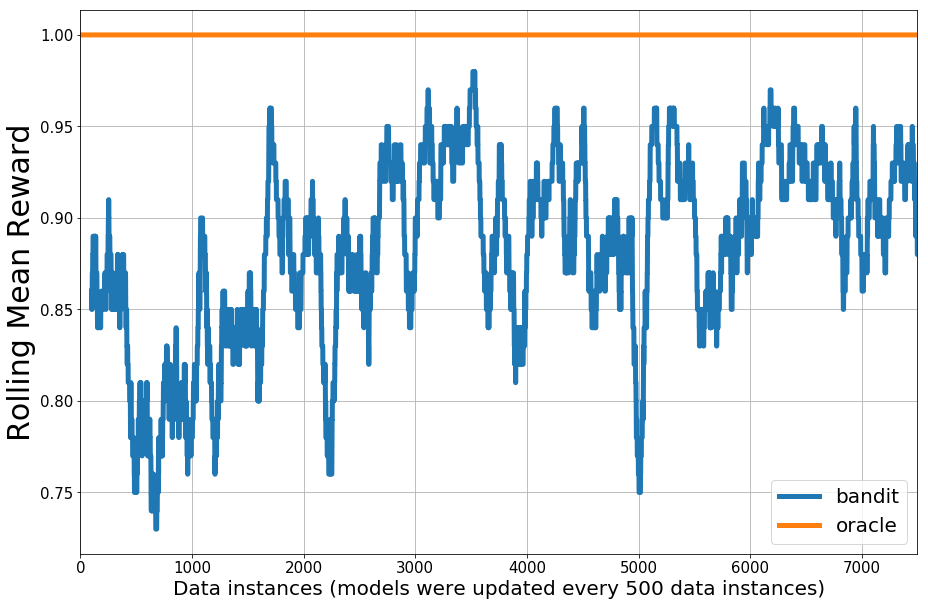

CPU times: user 553 ms, sys: 32.4 ms, total: 585 ms
Wall time: 757 ms


In [30]:
%%time
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 15, 10
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

rolling_window = 100
rewards_df = pd.DataFrame(rewards_list, columns=['bandit']).rolling(rolling_window).mean()
rewards_df['oracle'] = sum(sim_app.opt_rewards) / len(sim_app.opt_rewards)

rewards_df.plot(y=['bandit','oracle'],linewidth=lwd)
plt.legend(loc=4, prop={'size': 20})
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Data instances (models were updated every %s data instances)' % batch_size, size=20)
plt.ylabel('Rolling Mean Reward', size=30)
plt.grid()
plt.show()

#### Get mean rewards

In [31]:
rewards_df.bandit.mean()

0.8831022834751847

### Clean up

We have three DynamoDB tables (experiment, join, model) from the bandits application above (e.g. `experiment_id='bandits-exp-1'`). To better maintain them, we should remove the related records if the experiment has finished. Besides, having an endpoint running will incur costs. Therefore, we delete these components as part of the clean up process.

> Only execute the clean up cells below when you've finished the current experiment and want to deprecate everything associated with it. After the cleanup, the Cloudwatch metrics will not be populated anymore.

In [ ]:
bandits_experiment.clean_resource(experiment_id=bandits_experiment.experiment_id)

In [ ]:
bandits_experiment.clean_table_records(experiment_id=bandits_experiment.experiment_id)

In [32]:
!git status

fatal: Not a git repository (or any parent up to mount point /home/ec2-user)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
